In [1]:
import sys
from os.path import join
import torch
import matplotlib.pyplot as plt
sys.path.append("/n/holylabs/LABS/sompolinsky_lab/Everyone/xupan/DiffusionObjectRelation/PixArt-alpha")
from diffusion.utils.misc import read_config, set_random_seed, \
    init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/holylabs/LABS/sompolinsky_lab/Everyone/xupan/DiffusionObjectRelation")
from utils.pixart_sampling_utils import visualize_prompts, load_embed_and_mask
from utils.pixart_utils import construct_diffuser_pipeline_from_config, construct_pixart_transformer_from_config, state_dict_convert
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store

# subclass a new pipeline from PixArtAlphaPipeline
import os
import torch
from torch.autograd.functional import jacobian
from torch import vmap # Import vmap
from typing import Callable, List, Optional, Tuple, Union, Dict, Any
from diffusers.pipelines.pipeline_utils import DiffusionPipeline, ImagePipelineOutput
from diffusers.pipelines.pixart_alpha.pipeline_pixart_alpha import retrieve_timesteps, PixArtAlphaPipeline
import numpy as np
# from diffusers.pipelines.pixart_alpha import EXAMPLE_DOC_STRING # Keep commented

class PixArtAlphaPipeline_custom_jacobian(PixArtAlphaPipeline):
    
    # @replace_example_docstring(EXAMPLE_DOC_STRING)
    def __call__(
        self,
        prompt: Union[str, List[str]] = None,
        negative_prompt: str = "",
        num_inference_steps: int = 20,
        timesteps: List[int] = None,
        sigmas: List[float] = None,
        guidance_scale: float = 4.5,
        num_images_per_prompt: Optional[int] = 1,
        height: Optional[int] = None,
        width: Optional[int] = None,
        eta: float = 0.0,
        generator: Optional[Union[torch.Generator, List[torch.Generator]]] = None,
        latents: Optional[torch.Tensor] = None,
        prompt_embeds: Optional[torch.Tensor] = None,
        prompt_attention_mask: Optional[torch.Tensor] = None,
        negative_prompt_embeds: Optional[torch.Tensor] = None,
        negative_prompt_attention_mask: Optional[torch.Tensor] = None,
        output_type: Optional[str] = "pil",
        return_dict: bool = True,
        callback: Optional[Callable[[int, int, torch.Tensor], None]] = None,
        callback_steps: int = 1,
        clean_caption: bool = True,
        use_resolution_binning: bool = True,
        max_sequence_length: int = 120,
        return_sample_pred_traj: bool = False,
        device: str = "cuda",
        weight_dtype: torch.dtype = torch.float16,
        **kwargs,
    ) -> Union[ImagePipelineOutput, Tuple]:
        """
        Function invoked when calling the pipeline for generation.

        Args:
            prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts to guide the image generation. If not defined, one has to pass `prompt_embeds`.
                instead.
            negative_prompt (`str` or `List[str]`, *optional*):
                The prompt or prompts not to guide the image generation. If not defined, one has to pass
                `negative_prompt_embeds` instead. Ignored when not using guidance (i.e., ignored if `guidance_scale` is
                less than `1`).
            num_inference_steps (`int`, *optional*, defaults to 100):
                The number of denoising steps. More denoising steps usually lead to a higher quality image at the
                expense of slower inference.
            timesteps (`List[int]`, *optional*):
                Custom timesteps to use for the denoising process with schedulers which support a `timesteps` argument
                in their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is
                passed will be used. Must be in descending order.
            sigmas (`List[float]`, *optional*):
                Custom sigmas to use for the denoising process with schedulers which support a `sigmas` argument in
                their `set_timesteps` method. If not defined, the default behavior when `num_inference_steps` is passed
                will be used.
            guidance_scale (`float`, *optional*, defaults to 4.5):
                Guidance scale as defined in [Classifier-Free Diffusion Guidance](https://arxiv.org/abs/2207.12598).
                `guidance_scale` is defined as `w` of equation 2. of [Imagen
                Paper](https://arxiv.org/pdf/2205.11487.pdf). Guidance scale is enabled by setting `guidance_scale >
                1`. Higher guidance scale encourages to generate images that are closely linked to the text `prompt`,
                usually at the expense of lower image quality.
            num_images_per_prompt (`int`, *optional*, defaults to 1):
                The number of images to generate per prompt.
            height (`int`, *optional*, defaults to self.unet.config.sample_size):
                The height in pixels of the generated image.
            width (`int`, *optional*, defaults to self.unet.config.sample_size):
                The width in pixels of the generated image.
            eta (`float`, *optional*, defaults to 0.0):
                Corresponds to parameter eta (η) in the DDIM paper: https://arxiv.org/abs/2010.02502. Only applies to
                [`schedulers.DDIMScheduler`], will be ignored for others.
            generator (`torch.Generator` or `List[torch.Generator]`, *optional*):
                One or a list of [torch generator(s)](https://pytorch.org/docs/stable/generated/torch.Generator.html)
                to make generation deterministic.
            latents (`torch.Tensor`, *optional*):
                Pre-generated noisy latents, sampled from a Gaussian distribution, to be used as inputs for image
                generation. Can be used to tweak the same generation with different prompts. If not provided, a latents
                tensor will ge generated by sampling using the supplied random `generator`.
            prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated text embeddings. Can be used to easily tweak text inputs, *e.g.* prompt weighting. If not
                provided, text embeddings will be generated from `prompt` input argument.
            prompt_attention_mask (`torch.Tensor`, *optional*): Pre-generated attention mask for text embeddings.
            negative_prompt_embeds (`torch.Tensor`, *optional*):
                Pre-generated negative text embeddings. For PixArt-Alpha this negative prompt should be "". If not
                provided, negative_prompt_embeds will be generated from `negative_prompt` input argument.
            negative_prompt_attention_mask (`torch.Tensor`, *optional*):
                Pre-generated attention mask for negative text embeddings.
            output_type (`str`, *optional*, defaults to `"pil"`):
                The output format of the generate image. Choose between
                [PIL](https://pillow.readthedocs.io/en/stable/): `PIL.Image.Image` or `np.array`.
            return_dict (`bool`, *optional*, defaults to `True`):
                Whether or not to return a [`~pipelines.stable_diffusion.IFPipelineOutput`] instead of a plain tuple.
            callback (`Callable`, *optional*):
                A function that will be called every `callback_steps` steps during inference. The function will be
                called with the following arguments: `callback(step: int, timestep: int, latents: torch.Tensor)`.
            callback_steps (`int`, *optional*, defaults to 1):
                The frequency at which the `callback` function will be called. If not specified, the callback will be
                called at every step.
            clean_caption (`bool`, *optional*, defaults to `True`):
                Whether or not to clean the caption before creating embeddings. Requires `beautifulsoup4` and `ftfy` to
                be installed. If the dependencies are not installed, the embeddings will be created from the raw
                prompt.
            use_resolution_binning (`bool` defaults to `True`):
                If set to `True`, the requested height and width are first mapped to the closest resolutions using
                `ASPECT_RATIO_1024_BIN`. After the produced latents are decoded into images, they are resized back to
                the requested resolution. Useful for generating non-square images.
            max_sequence_length (`int` defaults to 120): Maximum sequence length to use with the `prompt`.

        Examples:

        Returns:
            [`~pipelines.ImagePipelineOutput`] or `tuple`:
                If `return_dict` is `True`, [`~pipelines.ImagePipelineOutput`] is returned, otherwise a `tuple` is
                returned where the first element is a list with the generated images
        """
        if "mask_feature" in kwargs:
            deprecation_message = "The use of `mask_feature` is deprecated. It is no longer used in any computation and that doesn't affect the end results. It will be removed in a future version."
            # deprecate("mask_feature", "1.0.0", deprecation_message, standard_warn=False)
        # 1. Check inputs. Raise error if not correct
        height = height or self.transformer.config.sample_size * self.vae_scale_factor
        width = width or self.transformer.config.sample_size * self.vae_scale_factor
        # if use_resolution_binning:
        #     if self.transformer.config.sample_size == 128:
        #         aspect_ratio_bin = ASPECT_RATIO_1024_BIN
        #     elif self.transformer.config.sample_size == 64:
        #         aspect_ratio_bin = ASPECT_RATIO_512_BIN
        #     elif self.transformer.config.sample_size == 32:
        #         aspect_ratio_bin = ASPECT_RATIO_256_BIN
        #     else:
        #         raise ValueError("Invalid sample size")
        #     orig_height, orig_width = height, width
        #     height, width = self.image_processor.classify_height_width_bin(height, width, ratios=aspect_ratio_bin)

        self.check_inputs(
            prompt,
            height,
            width,
            negative_prompt,
            callback_steps,
            prompt_embeds,
            negative_prompt_embeds,
            prompt_attention_mask,
            negative_prompt_attention_mask,
        )

        # 2. Default height and width to transformer
        if prompt is not None and isinstance(prompt, str):
            batch_size = 1
        elif prompt is not None and isinstance(prompt, list):
            batch_size = len(prompt)
        else:
            batch_size = prompt_embeds.shape[0]
        
        # Save original batch size for Jacobian calculation later
        orig_batch_size = batch_size

        device = self._execution_device

        # here `guidance_scale` is defined analog to the guidance weight `w` of equation (2)
        # of the Imagen paper: https://arxiv.org/pdf/2205.11487.pdf . `guidance_scale = 1`
        # corresponds to doing no classifier free guidance.
        do_classifier_free_guidance = guidance_scale > 1.0

        # 3. Encode input prompt
        (
            prompt_embeds,
            prompt_attention_mask,
            negative_prompt_embeds,
            negative_prompt_attention_mask,
        ) = self.encode_prompt(
            prompt,
            do_classifier_free_guidance,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_images_per_prompt,
            device=device,
            prompt_embeds=prompt_embeds,
            negative_prompt_embeds=negative_prompt_embeds,
            prompt_attention_mask=prompt_attention_mask,
            negative_prompt_attention_mask=negative_prompt_attention_mask,
            clean_caption=clean_caption,
            max_sequence_length=max_sequence_length,
        )
        if do_classifier_free_guidance:
            prompt_embeds = torch.cat([negative_prompt_embeds, prompt_embeds], dim=0)
            prompt_attention_mask = torch.cat([negative_prompt_attention_mask, prompt_attention_mask], dim=0)
        # print(prompt_embeds.shape)
        # print(prompt_attention_mask.shape)
        # 4. Prepare timesteps
        timesteps, num_inference_steps = retrieve_timesteps(
            self.scheduler, num_inference_steps, device, timesteps, sigmas
        )
        
        # print(timesteps)

        # 5. Prepare latents.
        latent_channels = self.transformer.config.in_channels
        latents = self.prepare_latents(
            batch_size * num_images_per_prompt,
            latent_channels,
            height,
            width,
            prompt_embeds.dtype,
            device,
            generator,
            latents,
        )

        # 6. Prepare extra step kwargs. TODO: Logic should ideally just be moved out of the pipeline
        extra_step_kwargs = self.prepare_extra_step_kwargs(generator, eta)

        # 6.1 Prepare micro-conditions.
        added_cond_kwargs = {"resolution": None, "aspect_ratio": None}
        if self.transformer.config.sample_size == 128:
            resolution = torch.tensor([height, width]).repeat(batch_size * num_images_per_prompt, 1)
            aspect_ratio = torch.tensor([float(height / width)]).repeat(batch_size * num_images_per_prompt, 1)
            resolution = resolution.to(dtype=prompt_embeds.dtype, device=device)
            aspect_ratio = aspect_ratio.to(dtype=prompt_embeds.dtype, device=device)

            if do_classifier_free_guidance:
                resolution = torch.cat([resolution, resolution], dim=0)
                aspect_ratio = torch.cat([aspect_ratio, aspect_ratio], dim=0)

            added_cond_kwargs = {"resolution": resolution, "aspect_ratio": aspect_ratio}

        # 7. Denoising loop
        num_warmup_steps = max(len(timesteps) - num_inference_steps * self.scheduler.order, 0)

        pred_traj = []
        latents_traj = []
        t_traj = []
        jacobian_traj = []
        denoiser_traj = []
        with self.progress_bar(total=num_inference_steps) as progress_bar:
            for i, t in enumerate(timesteps):
                # Expand latents for classifier free guidance
                # latents shape is (orig_batch_size, C, H, W)
                latent_model_input = torch.cat([latents] * 2) if do_classifier_free_guidance else latents
                # latent_model_input shape is (2*orig_batch_size, C, H, W) or (orig_batch_size, C, H, W)

                # Scale the latents (scheduler input)
                latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                # Prepare timestep embedding
                current_timestep = t
                if not torch.is_tensor(current_timestep):
                    is_mps = latent_model_input.device.type == "mps"
                    if isinstance(current_timestep, float):
                        dtype = torch.float32 if is_mps else torch.float64
                    else:
                        dtype = torch.int32 if is_mps else torch.int64
                    current_timestep = torch.tensor([current_timestep], dtype=dtype, device=latent_model_input.device)
                elif len(current_timestep.shape) == 0:
                    current_timestep = current_timestep[None].to(latent_model_input.device)
                # Broadcast timestep to batch dimension
                # current_timestep shape is (2*orig_batch_size,) or (orig_batch_size,)
                current_timestep = current_timestep.expand(latent_model_input.shape[0])

                # Predict the noise residual using the transformer
                # prompt_embeds shape is (2*orig_batch_size, SeqLen, Dim) or (orig_batch_size, SeqLen, Dim)
                # prompt_attention_mask shape is (2*orig_batch_size, SeqLen) or (orig_batch_size, SeqLen)
                # added_cond_kwargs has tensors of shape (2*orig_batch_size, ...) or (orig_batch_size, ...)
                noise_pred_out = self.transformer(
                    latent_model_input,
                    encoder_hidden_states=prompt_embeds,
                    encoder_attention_mask=prompt_attention_mask,
                    timestep=current_timestep,
                    added_cond_kwargs=added_cond_kwargs,
                    return_dict=False,
                )[0]
                # noise_pred_out shape is (2*orig_batch_size, C_out, H, W) or (orig_batch_size, C_out, H, W)

                # Perform classifier-free guidance
                if do_classifier_free_guidance:
                    noise_pred_uncond, noise_pred_text = noise_pred_out.chunk(2)
                    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                else:
                    noise_pred = noise_pred_out
                # noise_pred shape is (orig_batch_size, C_out, H, W)

                # Handle learned sigma prediction if necessary
                if self.transformer.config.out_channels // 2 == latent_channels:
                    # Assumes the model predicts both noise and variance, we take only the noise
                    noise_pred = noise_pred.chunk(2, dim=1)[0]
                # noise_pred final shape is (orig_batch_size, C, H, W)

                get_jacobian = False
                
                latents_shape = latents.shape
                latents_for_jacobian = latents.clone().detach().requires_grad_(True)
                # latents_for_jacobian = latents_for_jacobian.reshape(latents_shape[0], -1)
               
                def func_for_jacobian(x):
                    latent_model_input = torch.cat([x] * 2) if do_classifier_free_guidance else x
                    # latent_model_input shape is (2*orig_batch_size, C, H, W) or (orig_batch_size, C, H, W)

                    # Scale the latents (scheduler input)
                    latent_model_input = self.scheduler.scale_model_input(latent_model_input, t)

                    # Prepare timestep embedding
                    current_timestep = t
                    if not torch.is_tensor(current_timestep):
                        is_mps = latent_model_input.device.type == "mps"
                        if isinstance(current_timestep, float):
                            dtype = torch.float32 if is_mps else torch.float64
                        else:
                            dtype = torch.int32 if is_mps else torch.int64
                        current_timestep = torch.tensor([current_timestep], dtype=dtype, device=latent_model_input.device)
                    elif len(current_timestep.shape) == 0:
                        current_timestep = current_timestep[None].to(latent_model_input.device)
                    # Broadcast timestep to batch dimension
                    # current_timestep shape is (2*orig_batch_size,) or (orig_batch_size,)
                    current_timestep = current_timestep.expand(latent_model_input.shape[0])

                    # Predict the noise residual using the transformer
                    # prompt_embeds shape is (2*orig_batch_size, SeqLen, Dim) or (orig_batch_size, SeqLen, Dim)
                    # prompt_attention_mask shape is (2*orig_batch_size, SeqLen) or (orig_batch_size, SeqLen)
                    # added_cond_kwargs has tensors of shape (2*orig_batch_size, ...) or (orig_batch_size, ...)
                    noise_pred_out = self.transformer(
                        latent_model_input,
                        encoder_hidden_states=prompt_embeds,
                        encoder_attention_mask=prompt_attention_mask,
                        timestep=current_timestep,
                        added_cond_kwargs=added_cond_kwargs,
                        return_dict=False,
                    )[0]
                    # noise_pred_out shape is (2*orig_batch_size, C_out, H, W) or (orig_batch_size, C_out, H, W)

                    # Perform classifier-free guidance
                    if do_classifier_free_guidance:
                        noise_pred_uncond, noise_pred_text = noise_pred_out.chunk(2)
                        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
                        noise_pred = noise_pred.chunk(2, dim=1)[0]
                    else:
                        noise_pred = noise_pred_out
                    # Flatten the noise prediction
                    # return noise_pred.flatten()
                    return noise_pred
                
                # Compute the Jacobian of the noise prediction with respect to the latents
                jacobian = torch.autograd.functional.jacobian(func_for_jacobian, latents_for_jacobian)
                jacobian_traj.append(jacobian.detach().cpu())
                # jacobian = jacobian.reshape(latents_shape[0], -1, latents_shape[1], latents_shape[2], latents_shape[3])

                # Store trajectories (use original latents, not the one requiring grad)
                latents_traj.append(latents)
                pred_traj.append(noise_pred.cpu()) # Store the final noise prediction used for the step

                # Compute the previous noisy sample x_t -> x_t-1 using the scheduler
                # Use the original `latents` tensor, which does not require grad here.
                
                # save denoiser
                # print(self.scheduler.step_index)
                if self.scheduler.step_index is None:
                    self.scheduler._init_step_index(t)
                denoiser_traj.append(self.scheduler.convert_model_output(model_output=noise_pred, sample=latents))
                
                if num_inference_steps == 1:
                    # Special case for single-step sampling (e.g., DMD)
                    latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs).pred_original_sample
                else:
                    # Standard scheduler step
                    latents = self.scheduler.step(noise_pred, t, latents, **extra_step_kwargs, return_dict=False)[0]
                
                # Store timestep
                t_traj.append(t)

                # Call the callback, if provided, and update progress bar
                if i == len(timesteps) - 1 or ((i + 1) > num_warmup_steps and (i + 1) % self.scheduler.order == 0):
                    progress_bar.update()
                    if callback is not None and i % callback_steps == 0:
                        step_idx = i // getattr(self.scheduler, "order", 1)
                        callback(step_idx, t, latents)

        latents_traj.append(latents)
        
        images = []
        if not output_type == "latent":
            images.append(latents_traj[-1])
            # for i in range(len(latents_traj)):
            #     image = self.vae.decode(latents_traj[i] / self.vae.config.scaling_factor, return_dict=False)[0]
            #     image = self.image_processor.postprocess(image.detach(), output_type=output_type)
                # images.append(image)
                # if use_resolution_binning:
            #     image = self.image_processor.resize_and_crop_tensor(image, orig_width, orig_height)
        else:
            for i in range(len(latents_traj)):
                image = self.vae.decode(latents_traj[i].to(weight_dtype) / self.vae.config.scaling_factor, return_dict=False)[0]
                image = self.image_processor.postprocess(image.detach(), output_type="pil")
                images.append(image)
            # images = [ImagePipelineOutput(images=image) for image in images]

        # if not output_type == "latent":
        #     image = self.image_processor.postprocess(image.detach(), output_type=output_type)
        
        denoiser_image_traj = []
        for i in range(len(denoiser_traj)):
            image = self.vae.decode(denoiser_traj[i].to(weight_dtype) / self.vae.config.scaling_factor, return_dict=False)[0]
            image = self.image_processor.postprocess(image.detach(), output_type="pil")
            denoiser_image_traj.append(image)

        # Offload all models
        self.maybe_free_model_hooks()
        latents_traj = torch.stack(latents_traj)
        pred_traj = torch.stack(pred_traj)
        jacobian_traj = torch.stack(jacobian_traj)
        # t_traj = torch.stack(t_traj) # Stacking list of tensors might be inefficient if they are scalars
        if not return_dict:
            return (images,)
        if return_sample_pred_traj:
            # Convert t_traj list of tensors to a single tensor if needed, or return as list
            return images, pred_traj, [latent.cpu() for latent in latents_traj], t_traj, jacobian_traj, denoiser_image_traj
        return images
    
    
    
def visualize_prompts_with_traj_jacobian(pipeline, validation_prompts, prompt_cache_dir, max_length=120, weight_dtype=torch.float16,
                   num_inference_steps=14, guidance_scale=4.5, num_images_per_prompt=1, device="cuda", random_seed=0, return_sample_pred_traj=True): # Default num_images_per_prompt=1 for Jacobian
    # logger.info("Running validation... ")
    # device = accelerator.device
    # model = accelerator.unwrap_model(model)
    if validation_prompts is None:
        validation_prompts = [
            "triangle is to the upper left of square", 
            "blue triangle is to the upper left of red square", 
            "triangle is above and to the right of square", 
            "blue circle is above and to the right of blue square", 
            "triangle is to the left of square", 
            "triangle is to the left of triangle", 
            "circle is below red square",
            "red circle is to the left of blue square",
            "blue square is to the right of red circle",
            "red circle is above square",
            "triangle is above red circle",
            "red is above blue",
            "red is to the left of red",
            "blue triangle is above red triangle", 
            "blue circle is above blue square", 
        ]
    pipeline = pipeline.to(device)
    pipeline.set_progress_bar_config(disable=True)
    if random_seed is None:
        generator = None
    else:
        generator = torch.Generator(device=device).manual_seed(random_seed)
    image_logs = []
    images = []
    latents = []
    pred_traj_list = []
    latents_traj_list = []
    t_traj_list = []
    jacobian_traj_list = []
    denoiser_traj_list = []
    images_list = []
    uncond_data = torch.load(f'{prompt_cache_dir}/uncond_{max_length}token.pth', map_location='cpu')
    uncond_prompt_embeds = uncond_data['caption_embeds'].to(device)
    uncond_prompt_attention_mask = uncond_data['emb_mask'].to(device)
    visualized_prompts = []
    for _, prompt in enumerate(validation_prompts):
        if not os.path.exists(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth'):
            continue
        embed = torch.load(f'{prompt_cache_dir}/{prompt}_{max_length}token.pth', map_location='cpu')
        caption_embs, emb_masks = embed['caption_embeds'].to(device), embed['emb_mask'].to(device)
        
        # Ensure num_images_per_prompt=1 if calculating Jacobian for simplicity
        # The Jacobian code assumes orig_batch_size corresponds to prompt batch size
        current_num_images_per_prompt = 1 if return_sample_pred_traj else num_images_per_prompt 

        output = pipeline(
            num_inference_steps=num_inference_steps,
            num_images_per_prompt=current_num_images_per_prompt, 
            generator=generator,
            guidance_scale=guidance_scale,
            prompt_embeds=caption_embs,
            prompt_attention_mask=emb_masks,
            negative_prompt=None,
            negative_prompt_embeds=uncond_prompt_embeds,
            negative_prompt_attention_mask=uncond_prompt_attention_mask,
            use_resolution_binning=False, # need this for smaller images like ours. 
            return_sample_pred_traj=True, # Always true to get trajectories
            output_type="latent",
            weight_dtype=weight_dtype,
        )
        images_list.append(output[0])
        pred_traj_list.append(output[1])
        latents_traj_list.append(output[2])
        t_traj_list.append(output[3])
        jacobian_traj_list.append(output[4])
        denoiser_traj_list.append(output[5])
        visualized_prompts.append(prompt)
    # flush()
    # for latent in latents:
    #     # Handle potential batch dim if current_num_images_per_prompt > 1 was used
    #     if latent.dim() == 4: # Batch dimension exists
    #          img_batch = []
    #          for i in range(latent.shape[0]):
    #              img_batch.append(pipeline.vae.decode(latent[i:i+1].to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0])
    #          images.append(torch.cat(img_batch, dim=0)) # Reconstruct batch
    #     else: # Should not happen if pipeline returns correctly
    #          images.append(pipeline.vae.decode(latent.to(weight_dtype) / pipeline.vae.config.scaling_factor, return_dict=False)[0])

    # for prompt, image_batch in zip(visualized_prompts, images):
    #     processed_images = []
    #     # Handle batch dimension in postprocessing
    #     if image_batch.dim() == 4:
    #         for i in range(image_batch.shape[0]):
    #              img = pipeline.image_processor.postprocess(image_batch[i:i+1].detach(), output_type="pil")[0]
    #              processed_images.append(img)
    #     else: # Should not happen
    #          processed_images = pipeline.image_processor.postprocess(image_batch.detach(), output_type="pil")

    #     image_logs.append({"validation_prompt": prompt, "images": processed_images}) # Store list of PIL images
    
    # Return lists of trajectories, one element per prompt
    return images_list, latents_traj_list, pred_traj_list, t_traj_list, jacobian_traj_list, denoiser_traj_list

/n/holylabs/LABS/sompolinsky_lab/Users/xupan/envs/pixart/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/n/holylabs/LABS/sompolinsky_lab/Users/xupan/envs/pixart/lib/python3.10/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/n/holylabs/LABS/sompolinsky_lab/Users/xupan/envs/pixart/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mm

In [2]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"
ckptdir = join(savedir, "checkpoints")
config = read_config(join(savedir, 'config.py'))
weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
pipeline = construct_diffuser_pipeline_from_config(config, pipeline_class=PixArtAlphaPipeline_custom_jacobian)
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))
pipeline = pipeline.to("cuda")
pipeline.set_progress_bar_config(disable=True)

validation_prompts = config.validation_prompts
print("validation_prompts: ", validation_prompts)

prompt_cache_dir = config.prompt_cache_dir

from transformers import T5Tokenizer, T5EncoderModel

T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")

pipeline.transformer = replace_attn_processor(pipeline.transformer)

image_logs, latents_traj_list, pred_traj_list, t_traj_list, jacobian_traj, denoiser_traj= visualize_prompts_with_traj_jacobian(\
                                                                                        pipeline, 
                                                                                        validation_prompts[7:8], 
                                                                                        prompt_cache_dir, 
                                                                                        config.model_max_length, 
                                                                                        weight_dtype)


Loading pipeline components...: 100%|██████████| 3/3 [00:01<00:00,  2.38it/s]


validation_prompts:  ['triangle is to the upper left of square', 'blue triangle is to the upper left of red square', 'triangle is above and to the right of square', 'blue circle is above and to the right of blue square', 'triangle is to the left of square', 'triangle is to the left of triangle', 'circle is below red square', 'red circle is to the left of blue square', 'blue square is to the right of red circle', 'red circle is above square', 'triangle is above red circle', 'red is above blue', 'red is to the left of red', 'blue triangle is above red triangle', 'blue circle is above blue square']


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/n/holylabs/LABS/sompolinsky_lab/Users/xupan/envs/pixart/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


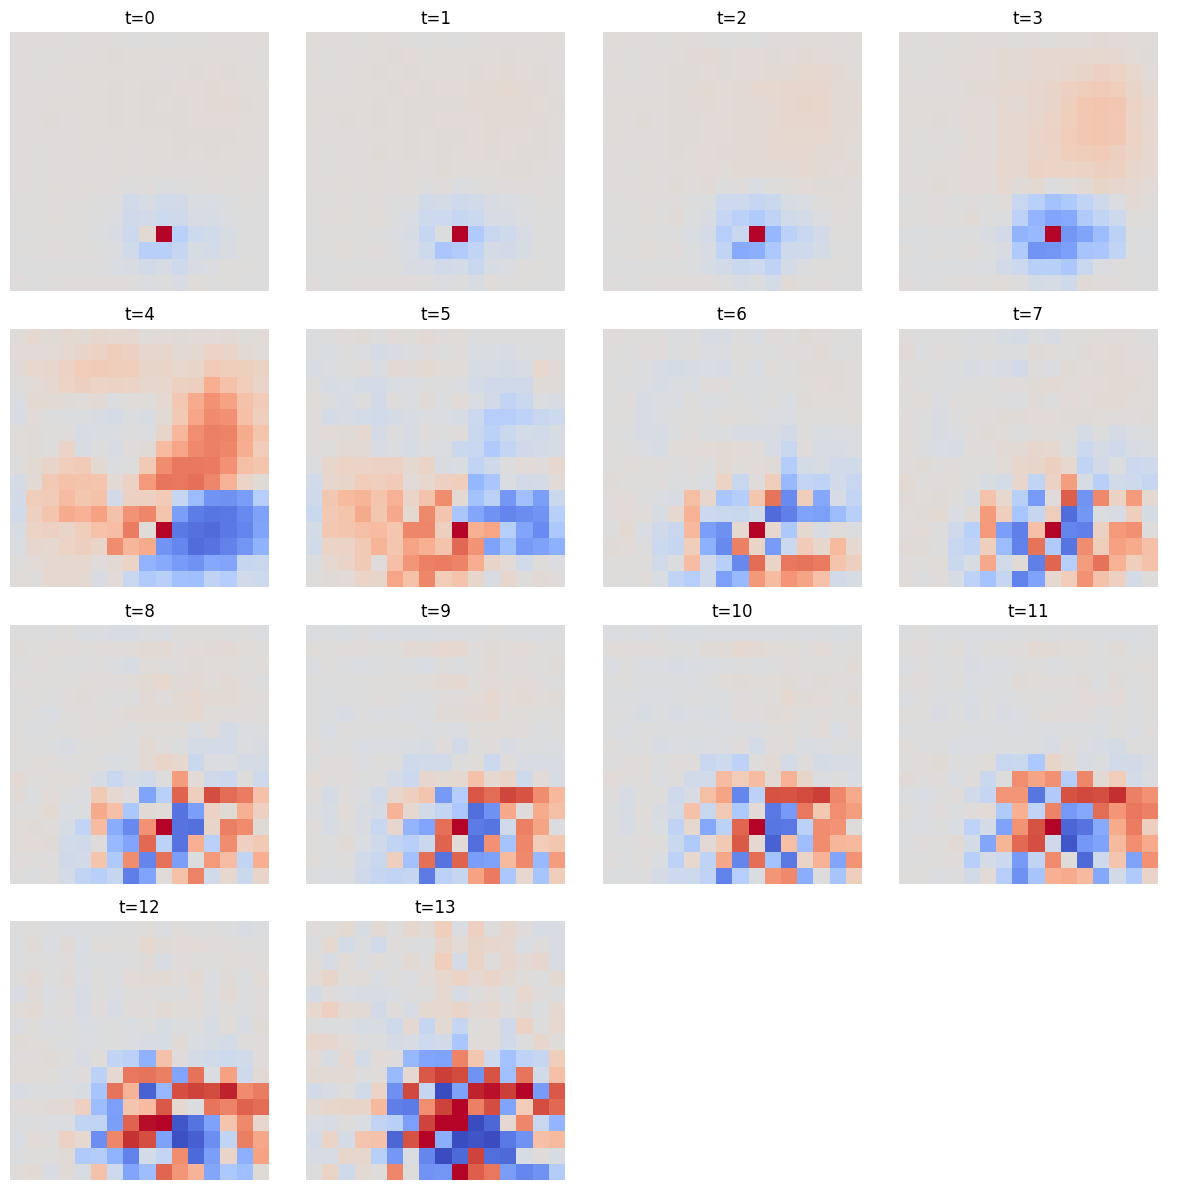

In [3]:
import matplotlib.colors as mcolors

jacobian_np = jacobian_traj[0].numpy()

n_plots = jacobian_np.shape[0]
ncols = int(np.ceil(np.sqrt(n_plots)))
nrows = int(np.ceil(n_plots / ncols))

x = 9
y = 12

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 3, nrows * 3)) # Adjust figsize as needed
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for t in range(n_plots):
    mean_jacobian = np.mean(jacobian_np[t,0,:,y,x,0,:,:,:], axis=(0,1))
    # Use SymLogNorm for log scaling while handling positive/negative values and zero
    
    # Adjust linthresh based on the data range near zero you want linear
    # Using the previous vmin/vmax for clipping within the norm
    norm = mcolors.SymLogNorm(linthresh=0.001, linscale=1.0, vmin=-0.01, vmax=0.01, base=10)
    im = axes[t].imshow(mean_jacobian, norm=norm, cmap='coolwarm') # Apply the norm
    axes[t].set_title(f"t={t}")
    axes[t].axis('off') # Hide axes ticks and labels

# Hide unused subplots
for i in range(n_plots, nrows * ncols):
    axes[i].axis('off')

# axes[-1].imshow(image_logs[0]['images'][0])

# Add a single colorbar for the entire figure
# fig.colorbar(im, ax=axes[:n_plots], shrink=0.6) # Adjust shrink factor as needed

plt.tight_layout()
plt.show()





In [4]:
# detect where is the objects

# Re-import necessary libraries
import cv2
import numpy as np
import pandas as pd
from PIL import Image

def find_classify_objects(image, area_threshold=100, radius=16.0):
    if isinstance(image, Image.Image):
        image = np.array(image)
    # gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    classified_objects = []
    # go through each color channel
    for channel in range(3):
        gray_image = image[:,:,channel]
        # Threshold the image to create a binary mask
        _, binary_mask = cv2.threshold(gray_image, 180, 255, cv2.THRESH_BINARY)
        # Find contours of the shapes
        contours, _ = cv2.findContours(binary_mask, 
                                    cv2.RETR_EXTERNAL, 
                                    cv2.CHAIN_APPROX_SIMPLE)
        # Initialize results
        for i, contour in enumerate(contours):
            # Calculate properties of the contour
            approx = cv2.approxPolyDP(contour, 0.04 * cv2.arcLength(contour, True), True)
            area = cv2.contourArea(contour)
            x, y, w, h = cv2.boundingRect(contour)
            # Shape classification based on the number of vertices
            if len(approx) == 3:
                shape = "Triangle"
                s = radius * 2  # Side length
                h = s * (3 ** 0.5) / 2  # Height of the equilateral triangle
                expected_area = s * h / 2
            elif len(approx) == 4:
                shape = "Square" if abs(w - h) < 5 else "Rectangle"
                s = radius * 2
                expected_area = s**2
            elif len(approx) > 4:
                shape = "Circle"
                expected_area = np.pi * radius ** 2
            else:
                shape = "Unknown"
                expected_area = np.nan
            # Calculate the color of the shape by extracting the region
            mask = np.zeros_like(gray_image)
            cv2.drawContours(mask, [contour], -1, 255, -1)
            mean_color = cv2.mean(image, mask=mask)
            # Add to results
            if area < area_threshold:
                continue
            classified_objects.append({
                "Object": i + 1,
                "Shape": shape,
                "Color (RGB)": tuple(map(int, mean_color[:3])),
                "Center (x, y)": (x + w // 2, y + h // 2),
                "Area": area,
                "Expected Area": expected_area
            })

    # Convert to DataFrame for better visualization
    classified_objects_df = pd.DataFrame(classified_objects)
    classified_objects_df
    return classified_objects_df
# Display the classification results to the user
# import ace_tools as tools; tools.display_dataframe_to_user(name="Shape and Color Classification Results", dataframe=classified_objects_df)


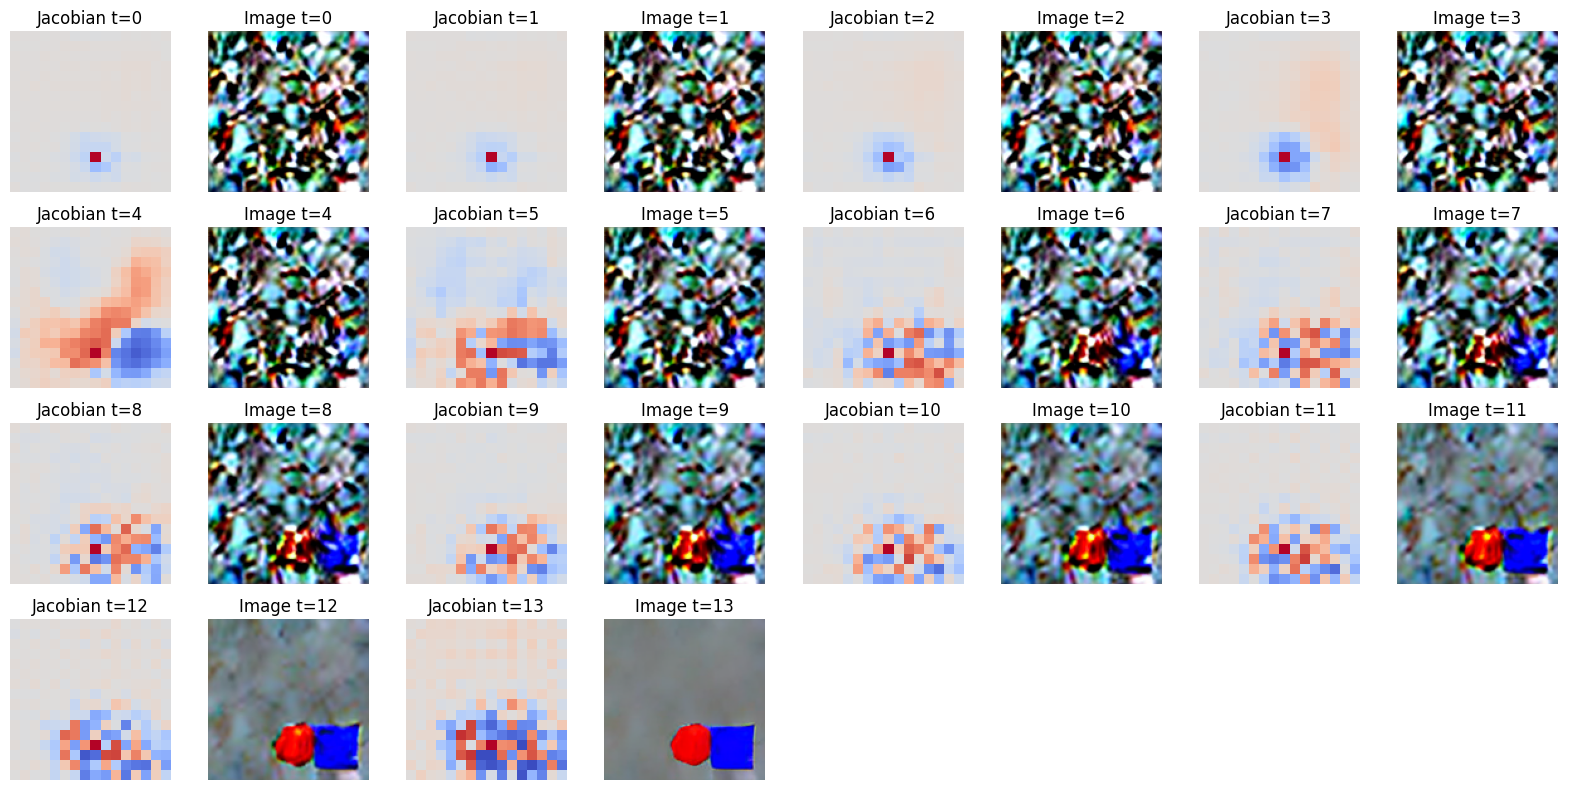

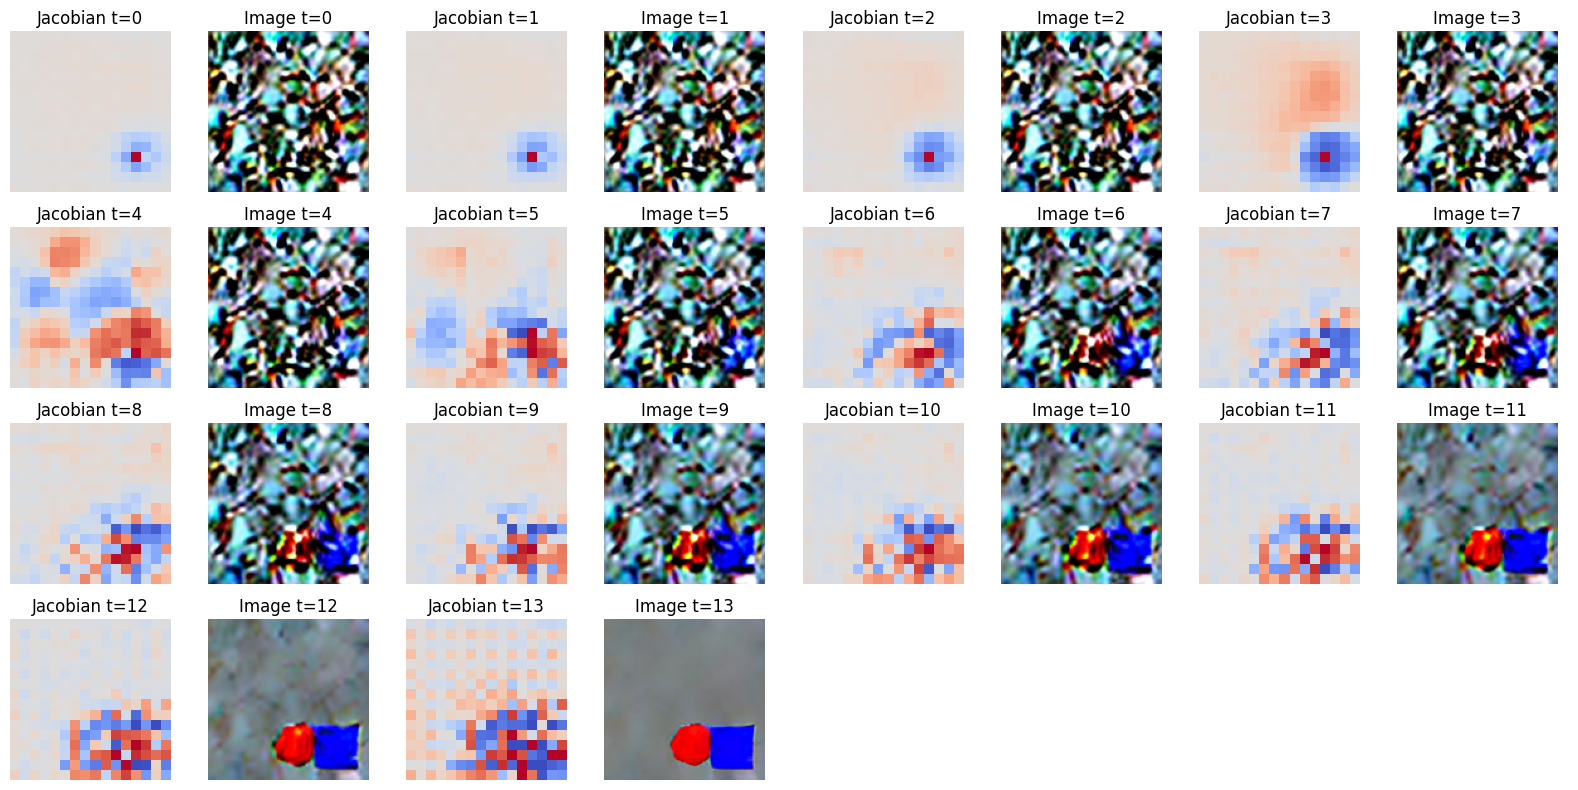

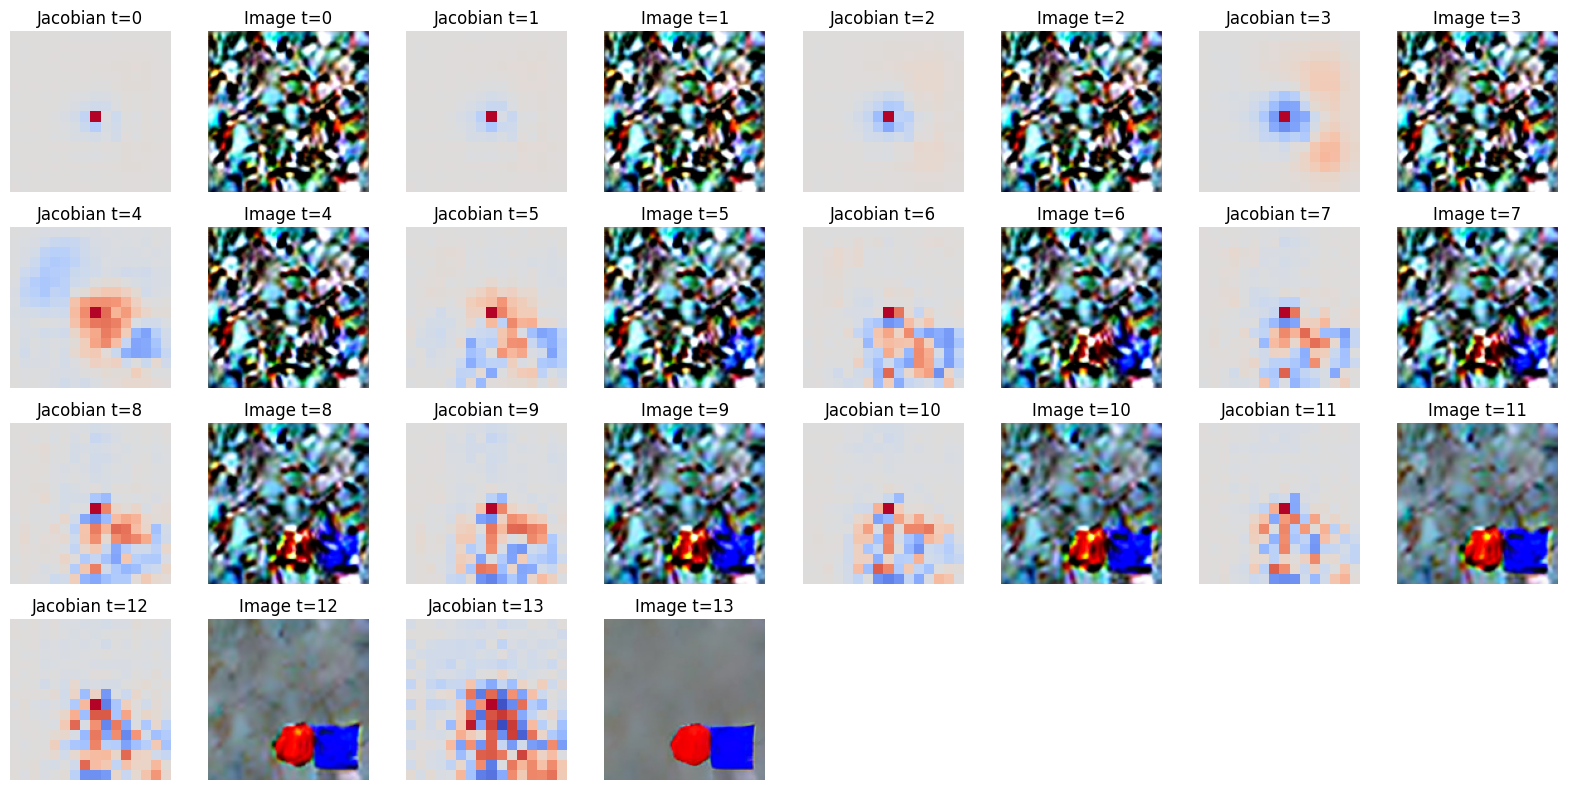

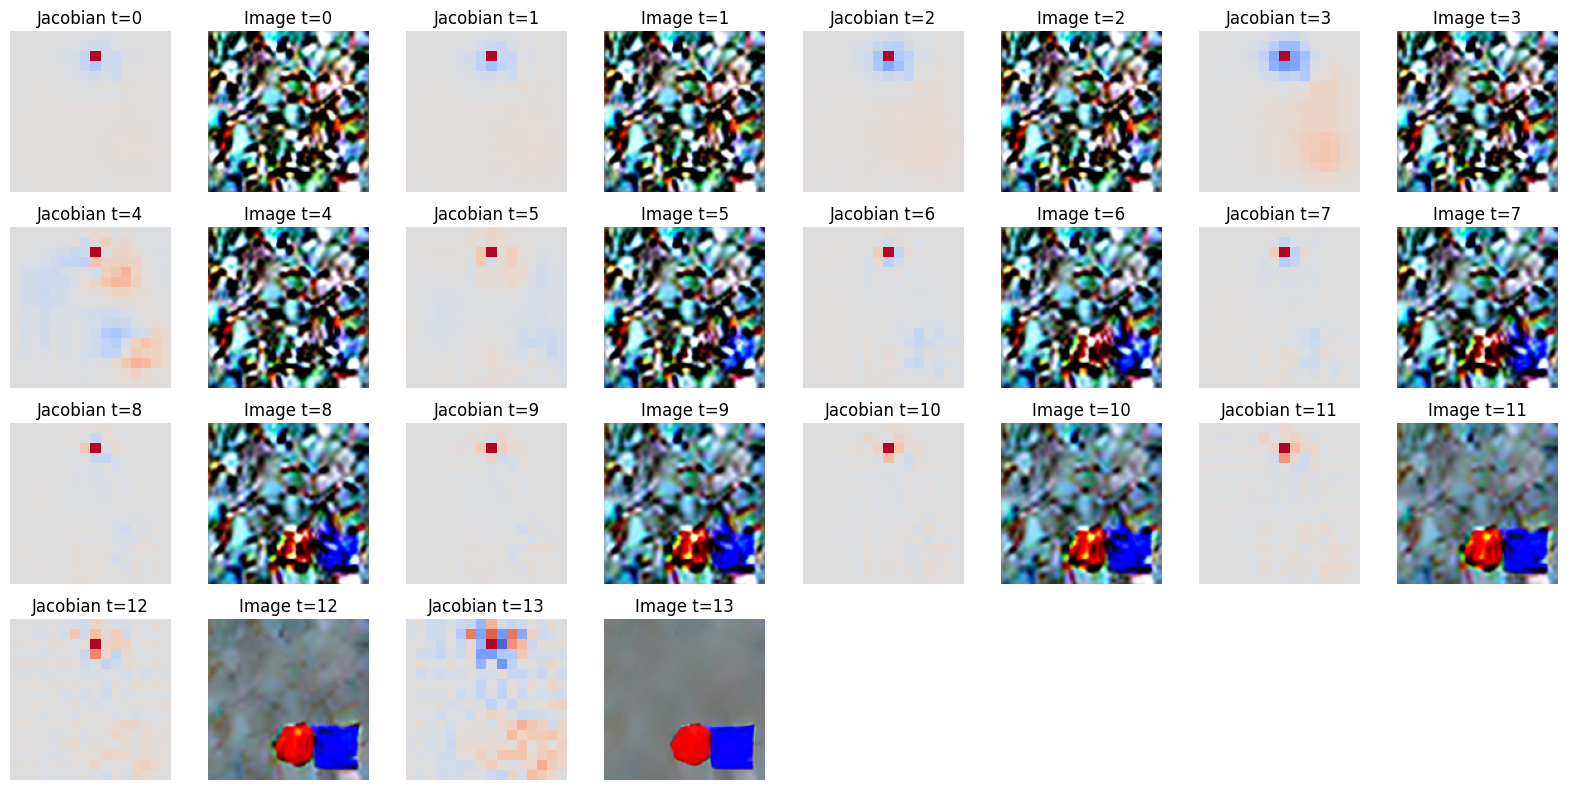

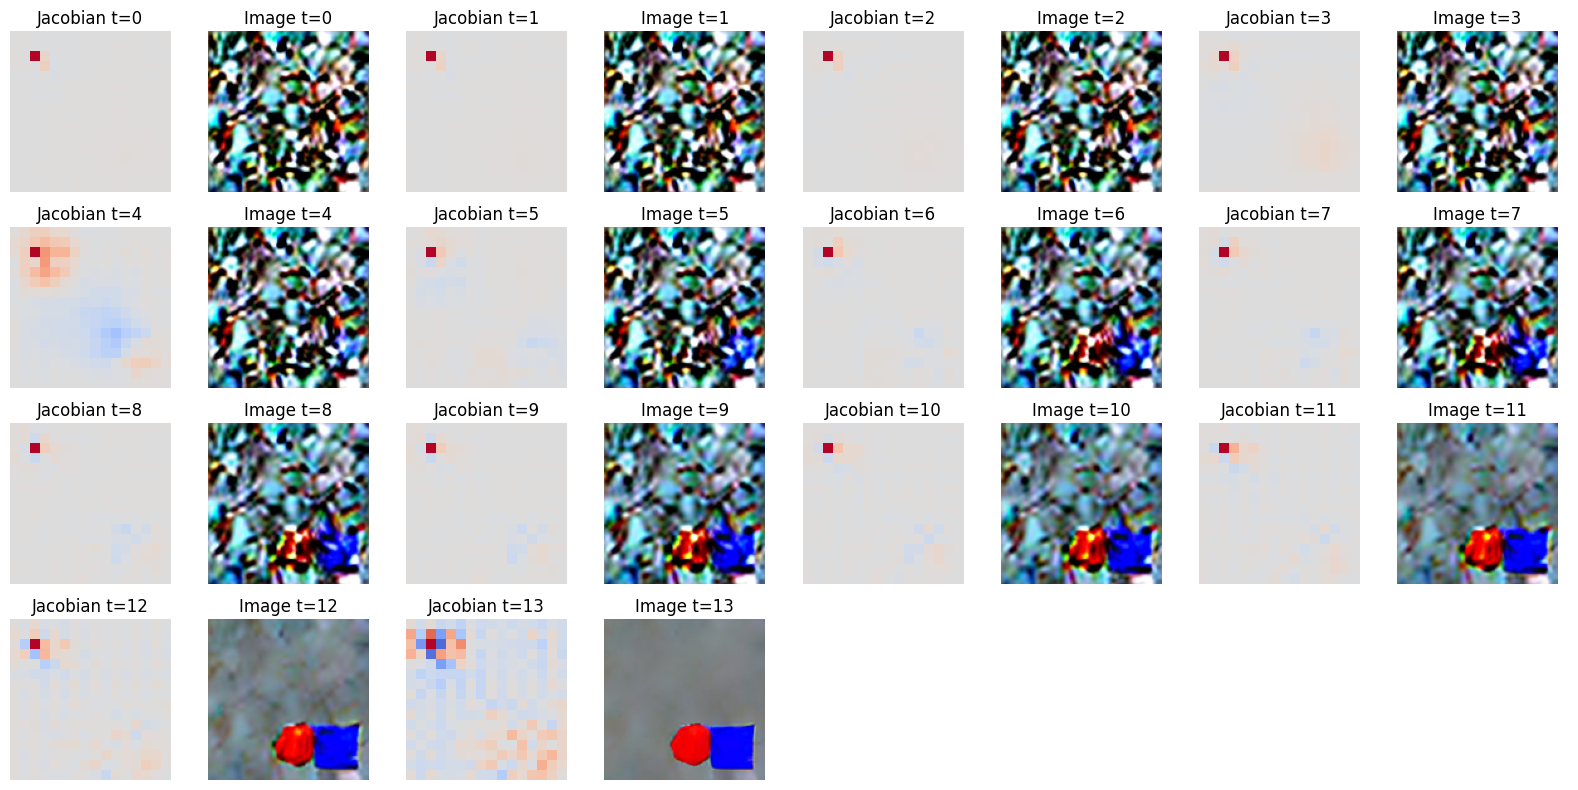

In [5]:
import matplotlib.colors as mcolors

jacobian_np = jacobian_traj[0].numpy()
images = image_logs[0]

cv2_objects = find_classify_objects(image_logs[0][-1][-1])
object_location = list(cv2_objects['Center (x, y)'])

n_plots = jacobian_np.shape[0]

# Make the plot grid as square as possible, with 2 columns per plot (jacobian, image)
n_pairs = n_plots
ncols = int(np.ceil(np.sqrt(n_pairs))) * 2  # 2 columns per plot (jacobian, image)
nrows = int(np.ceil(n_pairs / (ncols // 2)))

patch_size = 8

object_location += [(64,64), (64,20), (20,20)]

for (x,y) in object_location:
    x = round(x/patch_size-0.5)
    y = round(y/patch_size-0.5)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))

    # Ensure axes is always 2D
    if nrows == 1:
        axes = np.expand_dims(axes, 0)
    if ncols == 2:
        axes = np.expand_dims(axes, 1)

    for idx in range(n_plots):
        pair_idx = idx
        row = pair_idx // (ncols // 2)
        col_jac = (pair_idx % (ncols // 2)) * 2
        col_img = col_jac + 1

        # Plot jacobian
        mean_jacobian = np.mean(jacobian_np[idx,0,:,y,x,0,:,:,:], axis=(0,1))
        norm = mcolors.SymLogNorm(linthresh=0.001, linscale=1.0, vmin=-0.01, vmax=0.01, base=10)
        im = axes[row, col_jac].imshow(mean_jacobian, norm=norm, cmap='coolwarm')
        axes[row, col_jac].set_title(f"Jacobian t={idx}")
        axes[row, col_jac].axis('off')

        # Plot corresponding image (if available)
        if idx < len(images):
            axes[row, col_img].imshow(images[idx][0])
            axes[row, col_img].set_title(f"Image t={idx}")
            axes[row, col_img].axis('off')
        else:
            axes[row, col_img].axis('off')

    # Hide any unused subplots
    for i in range(nrows):
        for j in range(ncols):
            pair_idx = i * (ncols // 2) + (j // 2)
            if (j % 2 == 0 and pair_idx >= n_plots) or (j % 2 == 1 and pair_idx >= n_plots):
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()


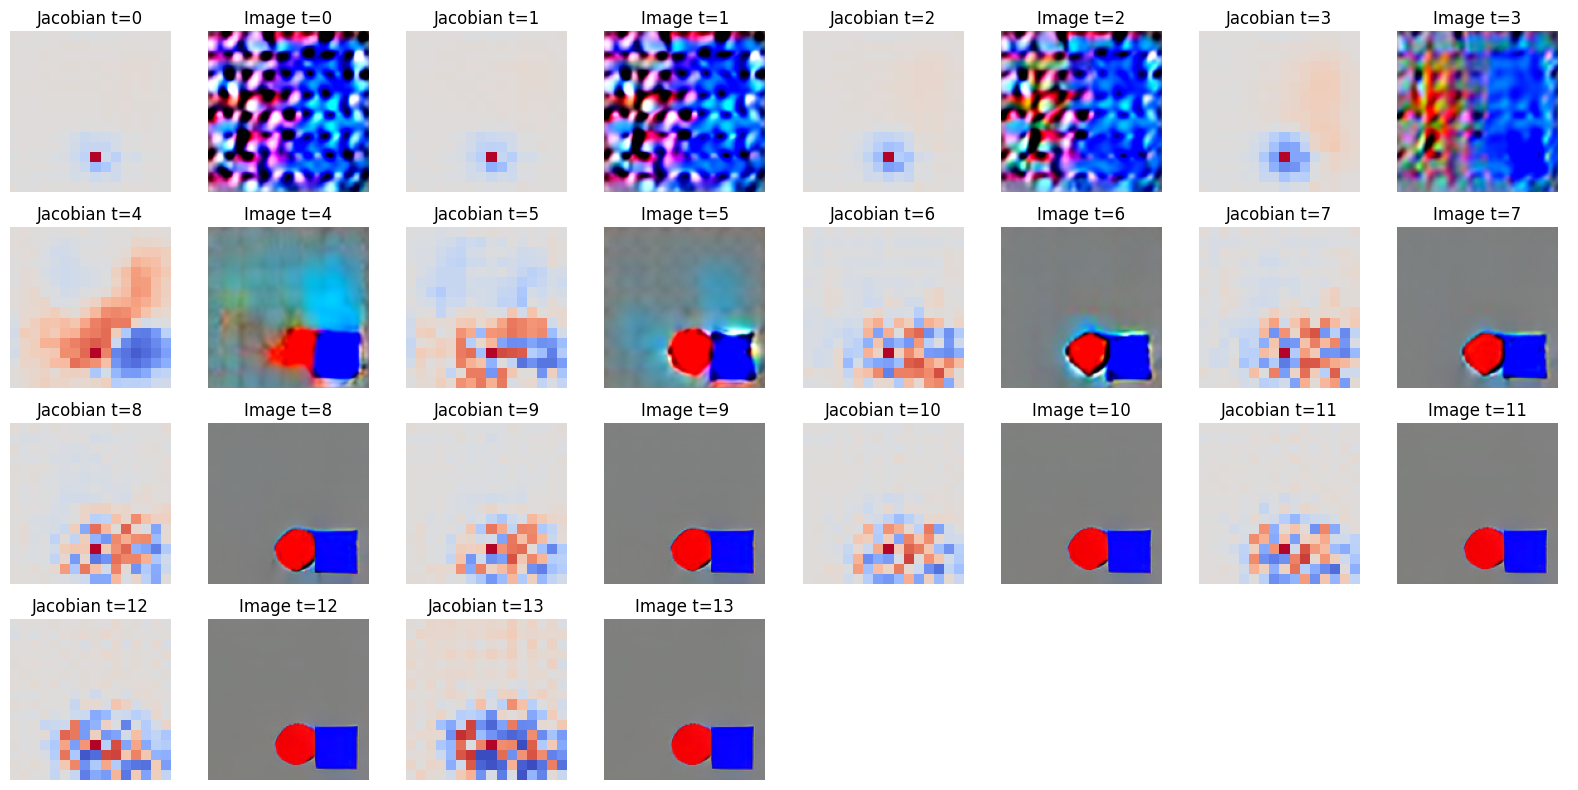

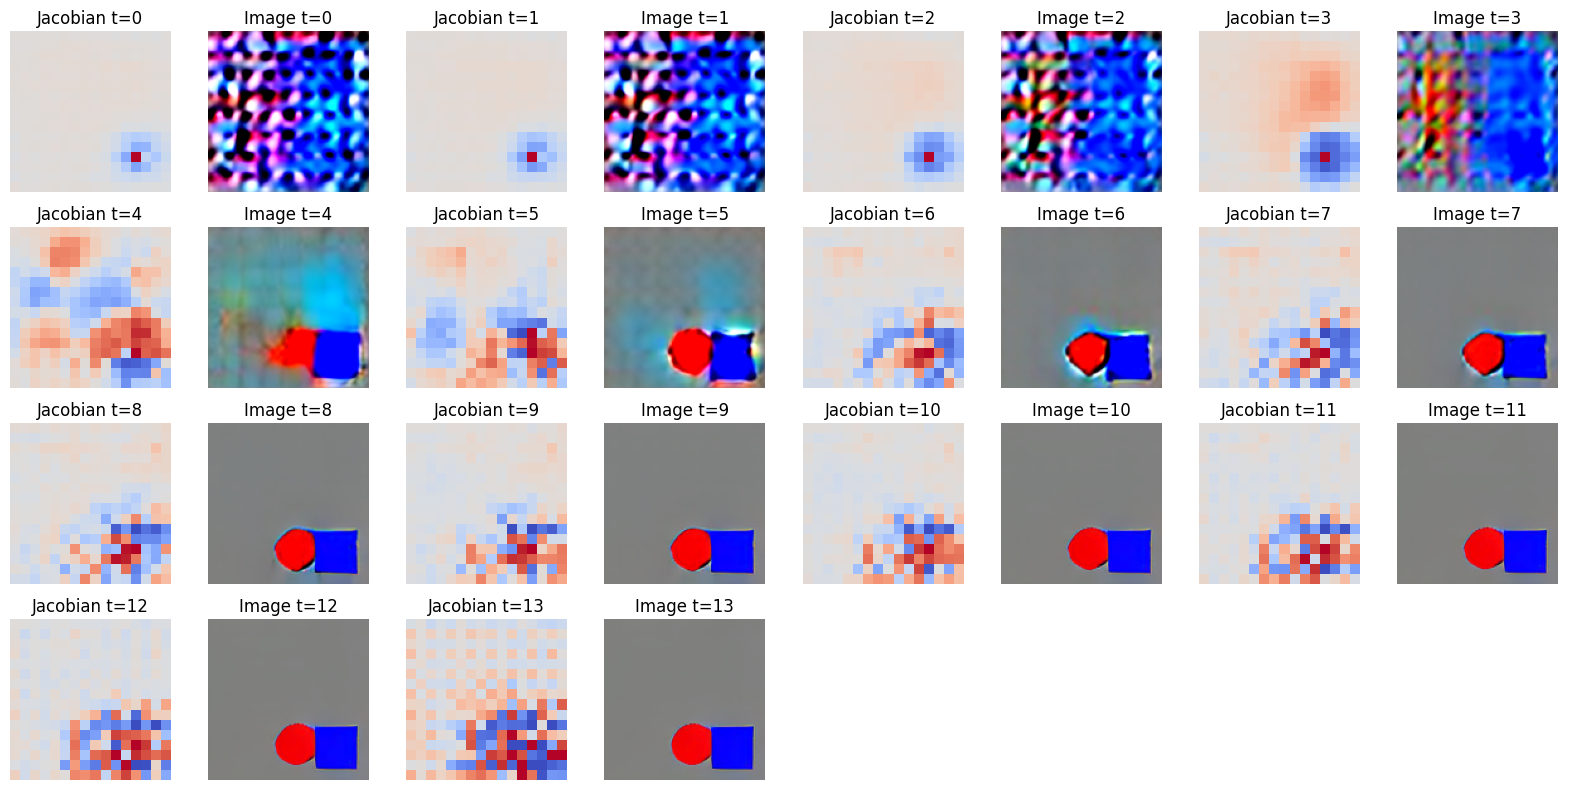

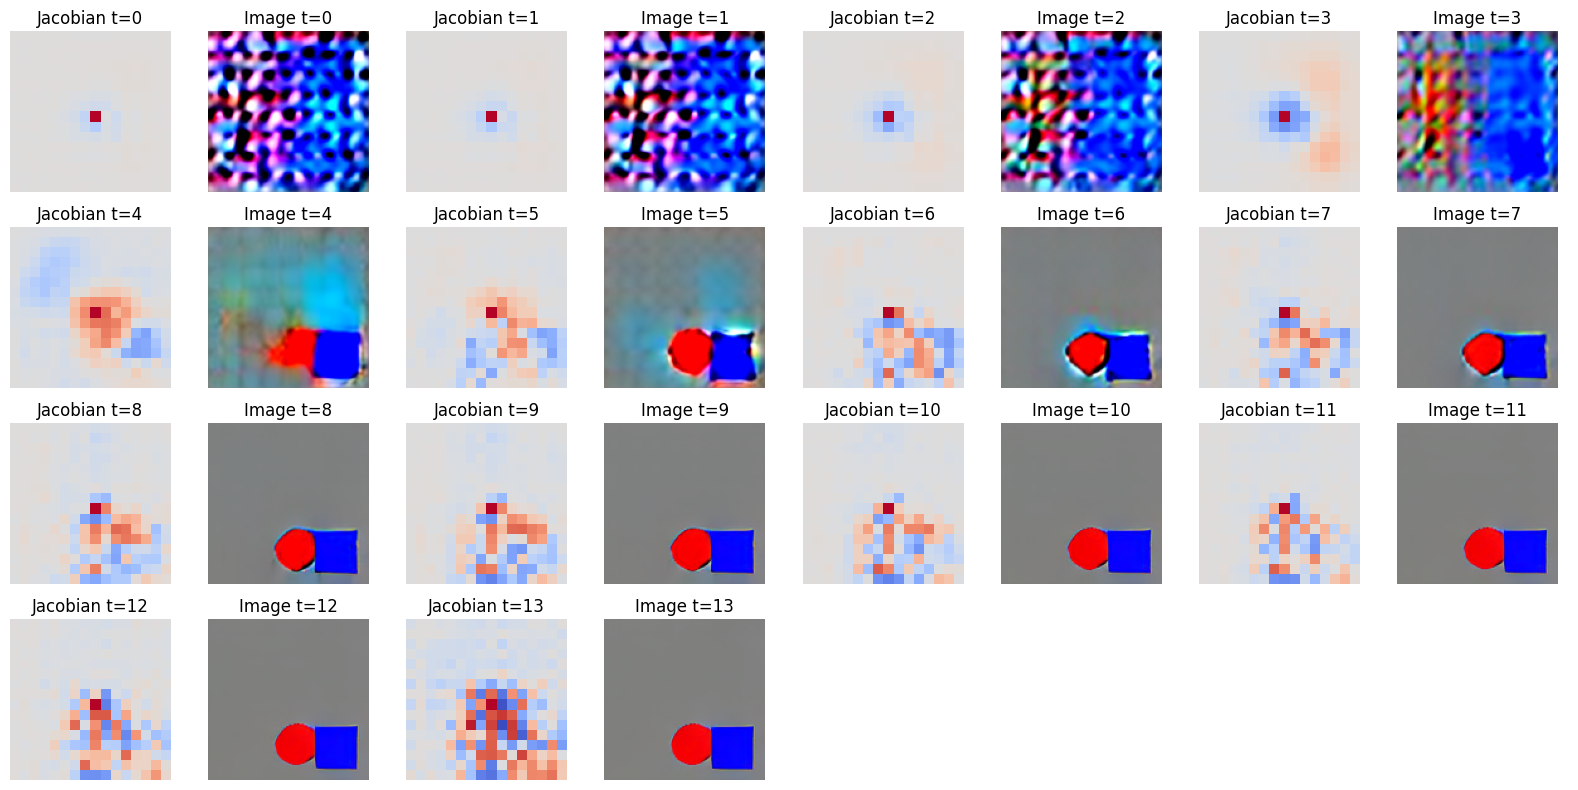

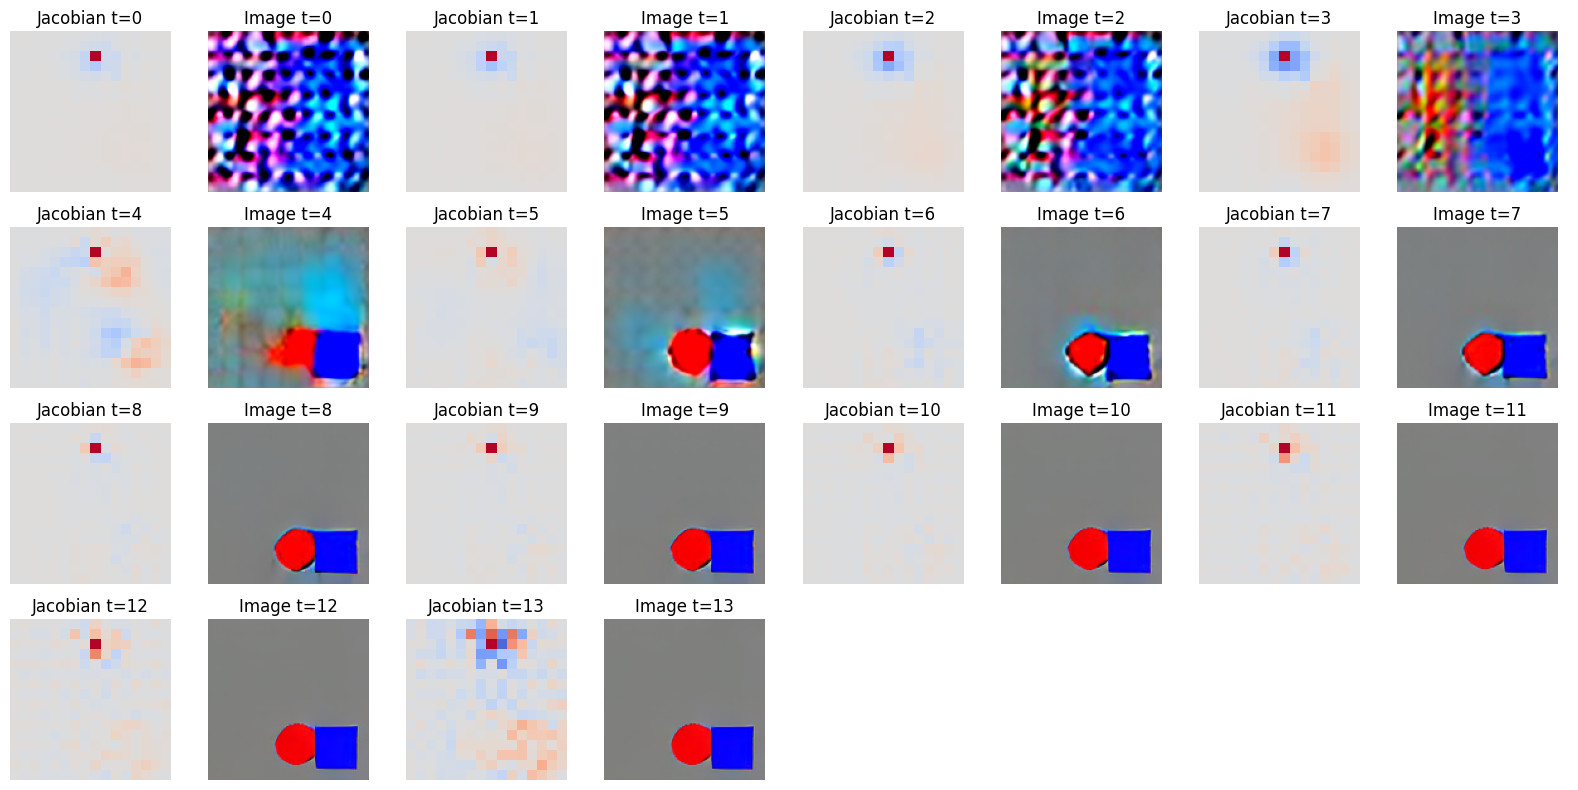

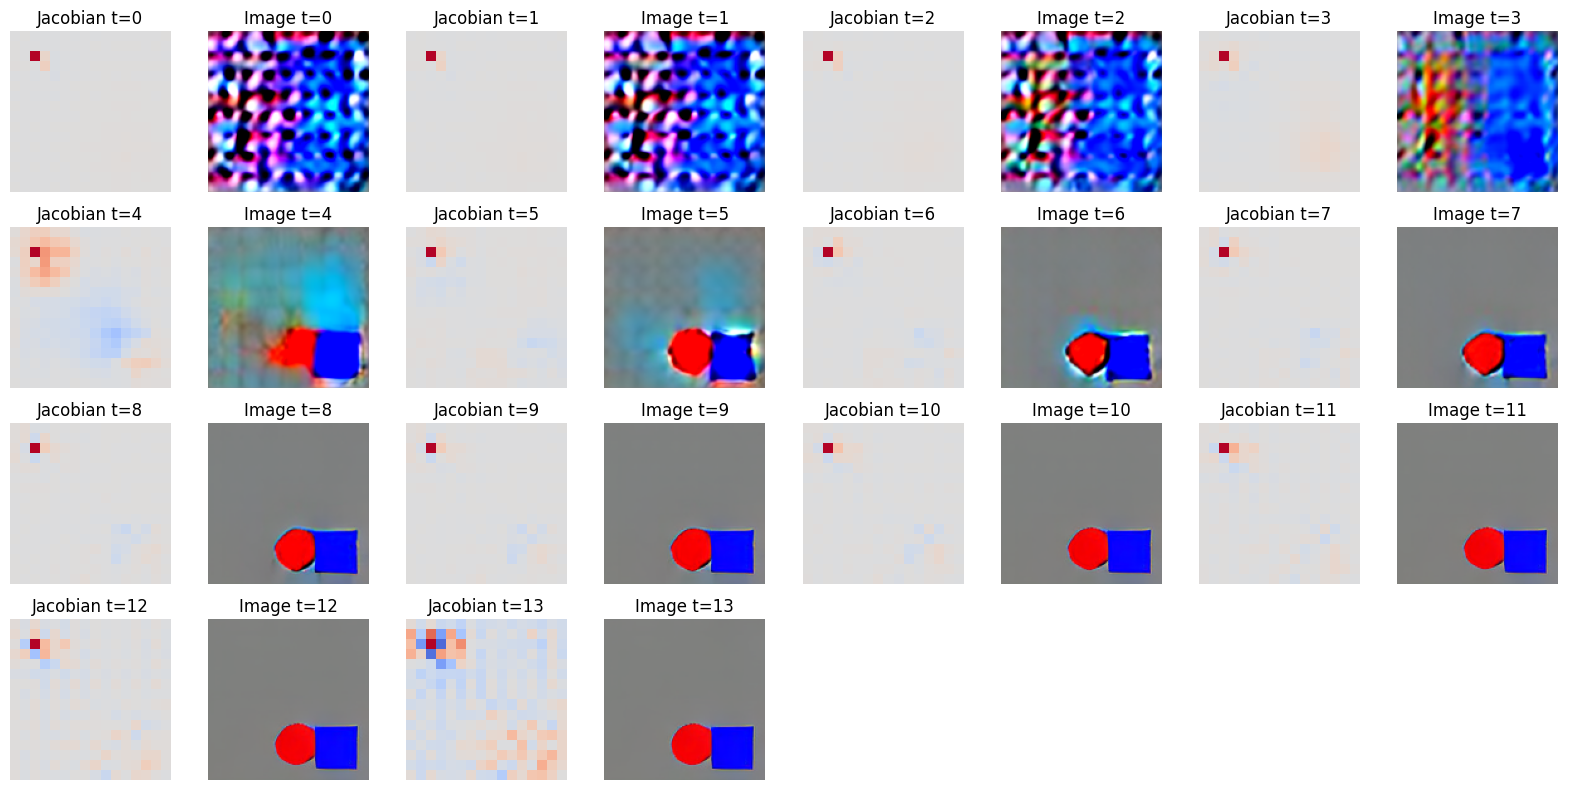

In [6]:
import matplotlib.colors as mcolors

jacobian_np = jacobian_traj[0].numpy()
images = denoiser_traj[0]

cv2_objects = find_classify_objects(image_logs[0][-1][-1])
object_location = list(cv2_objects['Center (x, y)'])

n_plots = jacobian_np.shape[0]

# Make the plot grid as square as possible, with 2 columns per plot (jacobian, image)
n_pairs = n_plots
ncols = int(np.ceil(np.sqrt(n_pairs))) * 2  # 2 columns per plot (jacobian, image)
nrows = int(np.ceil(n_pairs / (ncols // 2)))

patch_size = 8

object_location += [(64,64), (64,20), (20,20)]

for (x,y) in object_location:
    x = round(x/patch_size-0.5)
    y = round(y/patch_size-0.5)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))

    # Ensure axes is always 2D
    if nrows == 1:
        axes = np.expand_dims(axes, 0)
    if ncols == 2:
        axes = np.expand_dims(axes, 1)

    for idx in range(n_plots):
        pair_idx = idx
        row = pair_idx // (ncols // 2)
        col_jac = (pair_idx % (ncols // 2)) * 2
        col_img = col_jac + 1

        # Plot jacobian
        mean_jacobian = np.mean(jacobian_np[idx,0,:,y,x,0,:,:,:], axis=(0,1))
        norm = mcolors.SymLogNorm(linthresh=0.001, linscale=1.0, vmin=-0.01, vmax=0.01, base=10)
        im = axes[row, col_jac].imshow(mean_jacobian, norm=norm, cmap='coolwarm')
        axes[row, col_jac].set_title(f"Jacobian t={idx}")
        axes[row, col_jac].axis('off')

        # Plot corresponding image (if available)
        if idx < len(images):
            axes[row, col_img].imshow(images[idx][0])
            axes[row, col_img].set_title(f"Image t={idx}")
            axes[row, col_img].axis('off')
        else:
            axes[row, col_img].axis('off')

    # Hide any unused subplots
    for i in range(nrows):
        for j in range(ncols):
            pair_idx = i * (ncols // 2) + (j // 2)
            if (j % 2 == 0 and pair_idx >= n_plots) or (j % 2 == 1 and pair_idx >= n_plots):
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()


In [7]:
denoiser_traj[0][0].shape

AttributeError: 'list' object has no attribute 'shape'

In [4]:
pipeline.scheduler.config.prediction_type

'epsilon'

In [5]:
pipeline.scheduler.config.algorithm_type

'dpmsolver++'

In [6]:
pipeline.scheduler.config.solver_order

2

In [ ]:
pipeline.scheduler.step_index

In [6]:
pipeline.scheduler.timesteps

tensor([999, 928, 856, 785, 714, 642, 571, 500, 428, 357, 285, 214, 143,  71],
       device='cuda:0')